<a href="https://colab.research.google.com/github/pappg13/AppleTwitterSentiment/blob/main/Brandt_Krass_Papp_Teubner_Big_Data_in_Budgeting_and_Forecasting_in_Management_Accounting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Package and Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split

Vader is the lexicon that helps us to assign sentyment scores to the tweets.



In [3]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 12.4MB/s 


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [5]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [6]:
#This code does the categorisation. The compound score is the one that we need.
print_sentiment_scores("The class was AWESOME today!!!!!!!")

The class was AWESOME today!!!!!!!------ {'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.7906}


In [7]:
#Twitter data file was too large to upload it to GitHub so we split it into 2 parts. 
#First they are going to be imported separately, and then they will be merged.

tweet_part1_url = 'https://github.com/pappg13/AppleTwitterSentiment/blob/main/Tweets_part1.xlsx?raw=true'
tweet_part1 = pd.read_excel(tweet_part1_url)
#booking1.head()

tweet_part2_url = 'https://github.com/pappg13/AppleTwitterSentiment/blob/main/Tweets_part2.xlsx?raw=true'
tweet_part2 = pd.read_excel(tweet_part2_url)
#booking2.head()


tweets = pd.concat([tweet_part1, tweet_part2], ignore_index=True)
tweets.head()

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs
0,743056393796739072,2016-06-15,12:23,Sufiy,Sufiy,#Investing as a way of life based on common se...,RT @kirillklip: Race for #renewable #energy #t...,NaN,4.0,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/292857657/...,1798.0,2111.0,537.0,da,http://www.twitter.com/Sufiy/status/7430563937...,True,@kirillklip,@kirillklip,"#renewable,#energy,#technologies,#lithium,#hed...","$LIT,$ILV.v,$TSLA,$AAPL",NaN,http://www.bnn.ca/News/2016/5/7/Race-for-renew...
1,743055905214889984,2016-06-15,12:21,Breaking News,HotpageNews,One Stop Shop for BREAKING AND TRENDING NEWS. ...,#APPLE TRIES to Limit #Google Incursions Onto ...,NaN,NaN,42.35843,-71.05977,US,Boston,http://pbs.twimg.com/profile_images/5138456212...,222.0,346.0,163.0,en,http://www.twitter.com/HotpageNews/status/7430...,False,NaN,NaN,"#APPLE,#Google","$AAPL,$GOOG",NaN,http://hotpagenews.com/r/150730
2,743055905193857024,2016-06-15,12:21,Hotpage News,Hotpage_News,The One Stop WEBSITE for Breaking and Trending...,#APPLE TRIES to Limit #Google Incursions Onto ...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5138153039...,16177.0,1333.0,427.0,en,http://www.twitter.com/Hotpage_News/status/743...,False,NaN,NaN,"#APPLE,#Google","$AAPL,$GOOG",NaN,http://hotpagenews.com/r/150730
3,743055497725673472,2016-06-15,12:20,Danny,TraderDanny77,"Family Man, entrepreneur, wanna be trader, Tha...",What calls do I sell on $twtr\n\n$spy $aapl $g...,NaN,NaN,46.47747,30.73262,UA,"Odessa, FL",http://pbs.twimg.com/profile_images/7398402031...,87.0,406.0,5.0,en,http://www.twitter.com/TraderDanny77/status/74...,False,NaN,NaN,NaN,"$twtr,$spy,$aapl,$googl,$tsla,$ibm,$wba,$scty,...",NaN,NaN
4,743055311909441536,2016-06-15,12:19,Jayson,hovastocks,Father | Investor in life | Runner | Cyclist,Good for $AAPL pay? https://t.co/6EuitFi8Au,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/7185906846...,387.0,353.0,20.0,en,http://www.twitter.com/hovastocks/status/74305...,False,NaN,NaN,NaN,$AAPL,NaN,https://twitter.com/businessinsider/status/742...


In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166631 entries, 0 to 166630
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Tweet Id                    166631 non-null  int64  
 1   Date                        166631 non-null  object 
 2   Hour                        166631 non-null  object 
 3   User Name                   166631 non-null  object 
 4   Nickname                    166631 non-null  object 
 5   Bio                         142749 non-null  object 
 6   Tweet content               166631 non-null  object 
 7   Favs                        20706 non-null   float64
 8   RTs                         90074 non-null   float64
 9   Latitude                    59642 non-null   float64
 10  Longitude                   59642 non-null   float64
 11  Country                     59824 non-null   object 
 12  Place (as appears on Bio)   60010 non-null   object 
 13  Profile pictur

In [9]:
# Getting rid of columns in Tweets that we don't need


tweets = tweets.drop (['Nickname', 'Bio', 'Favs', 'RTs', 'Place (as appears on Bio)', 'Profile picture' , 'Followers', 'Following', 'Listed', 'Tweet Url', 'Is a RT', 'Original Tweet User Name', 'User Mentions', 'Hashtags', 'Symbols', 'Media', 'URLs'], axis = 1 )
tweets.head()

,Tweet Id,Date,Hour,User Name,Tweet content,Latitude,Longitude,Country,Tweet language (ISO 639-1)
0,743056393796739072,2016-06-15,12:23,Sufiy,RT @kirillklip: Race for #renewable #energy #t...,NaN,NaN,NaN,da
1,743055905214889984,2016-06-15,12:21,Breaking News,#APPLE TRIES to Limit #Google Incursions Onto ...,42.35843,-71.05977,US,en
2,743055905193857024,2016-06-15,12:21,Hotpage News,#APPLE TRIES to Limit #Google Incursions Onto ...,NaN,NaN,NaN,en
3,743055497725673472,2016-06-15,12:20,Danny,What calls do I sell on $twtr\n\n$spy $aapl $g...,46.47747,30.73262,UA,en
4,743055311909441536,2016-06-15,12:19,Jayson,Good for $AAPL pay? https://t.co/6EuitFi8Au,NaN,NaN,NaN,en


In [10]:
#As our model will be able to interpretTweets that are written in English only, we will drop thos tweets, where the Tweet language value is not 'en'
tweets=tweets.loc[tweets['Tweet language (ISO 639-1)']=='en']
tweets.head(10)

,Tweet Id,Date,Hour,User Name,Tweet content,Latitude,Longitude,Country,Tweet language (ISO 639-1)
1,743055905214889984,2016-06-15,12:21,Breaking News,#APPLE TRIES to Limit #Google Incursions Onto ...,42.35843,-71.05977,US,en
2,743055905193857024,2016-06-15,12:21,Hotpage News,#APPLE TRIES to Limit #Google Incursions Onto ...,NaN,NaN,NaN,en
3,743055497725673472,2016-06-15,12:20,Danny,What calls do I sell on $twtr\n\n$spy $aapl $g...,46.47747,30.73262,UA,en
4,743055311909441536,2016-06-15,12:19,Jayson,Good for $AAPL pay? https://t.co/6EuitFi8Au,NaN,NaN,NaN,en
5,743055468315185152,2016-06-15,12:20,Jennifer Booton,Apple may again see a super cycle akin to the ...,53.95800,-1.08300,GB,en
6,743055167143194624,2016-06-15,12:18,ciara linnane,Time to talk iPhone 8: Apple ‘super cycle’ exp...,53.95800,-1.08300,GB,en
7,743054736878936068,2016-06-15,12:17,Pete Rickels,Where will $AAPL pin on Friday's OPEX?,NaN,NaN,NaN,en
8,743053821732114433,2016-06-15,12:13,Danny,@jack $lnkd $twtr $spy $aapl $tsla $fb $ibm $s...,46.47747,30.73262,UA,en
9,743053820364783617,2016-06-15,12:13,Andreas Andersen,RT @andreascseh: #iPhone6s vs #iPhone7: 4 Reas...,47.49801,19.03991,HU,en
11,743053694564995073,2016-06-15,12:13,Ricky Samuel,RT @DayTradeWarrior: We now have a Paper #Trad...,NaN,NaN,NaN,en


In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159864 entries, 1 to 166630
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Tweet Id                    159864 non-null  int64  
 1   Date                        159864 non-null  object 
 2   Hour                        159864 non-null  object 
 3   User Name                   159864 non-null  object 
 4   Tweet content               159864 non-null  object 
 5   Latitude                    56892 non-null   float64
 6   Longitude                   56892 non-null   float64
 7   Country                     57066 non-null   object 
 8   Tweet language (ISO 639-1)  159864 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 12.2+ MB


So we successfully deleted 6766 rows, where the language was not English. Great!

In [12]:
#As we do not intend to use any other geographical metadata nor the identity of the user who posted the tweet, 
#the columns of ‘User name’, ‘Latitude’, ‘Longitude’, ‘Country’, ‘Tweet language (ISO 639-1)’ are dropped. 
tweets = tweets.drop (['Latitude', 'Longitude', 'Country', 'Tweet language (ISO 639-1)', 'User Name'], axis = 1 )
tweets.head()

,Tweet Id,Date,Hour,Tweet content
1,743055905214889984,2016-06-15,12:21,#APPLE TRIES to Limit #Google Incursions Onto ...
2,743055905193857024,2016-06-15,12:21,#APPLE TRIES to Limit #Google Incursions Onto ...
3,743055497725673472,2016-06-15,12:20,What calls do I sell on $twtr\n\n$spy $aapl $g...
4,743055311909441536,2016-06-15,12:19,Good for $AAPL pay? https://t.co/6EuitFi8Au
5,743055468315185152,2016-06-15,12:20,Apple may again see a super cycle akin to the ...


In [13]:
#The TweetID is a neutral number, but we will need this later to be able to concat our COMPOUND results with the details of the original tweet.
#Let's add the TweetID to the beginning of the 'Tweet content' column
tweets["toanalyze"] = tweets["Tweet Id"].astype(str) + ' ' + tweets["Tweet content"]
tweets.head()

,Tweet Id,Date,Hour,Tweet content,toanalyze
1,743055905214889984,2016-06-15,12:21,#APPLE TRIES to Limit #Google Incursions Onto ...,743055905214889984 #APPLE TRIES to Limit #Goog...
2,743055905193857024,2016-06-15,12:21,#APPLE TRIES to Limit #Google Incursions Onto ...,743055905193857024 #APPLE TRIES to Limit #Goog...
3,743055497725673472,2016-06-15,12:20,What calls do I sell on $twtr\n\n$spy $aapl $g...,743055497725673472 What calls do I sell on $tw...
4,743055311909441536,2016-06-15,12:19,Good for $AAPL pay? https://t.co/6EuitFi8Au,743055311909441536 Good for $AAPL pay? https:/...
5,743055468315185152,2016-06-15,12:20,Apple may again see a super cycle akin to the ...,743055468315185152 Apple may again see a super...


In [14]:
#Let's check the Compound score of a Tweet Id
print_sentiment_scores ("743055468315185152")

743055468315185152---------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [15]:
#Let's see the respective Tweet
print(tweets.loc[tweets['Tweet Id'] == 743055468315185152]['Tweet content'].values)

['Apple may again see a super cycle akin to the iPhone 6...but not until late 2017: https://t.co/LLFgiGGNDT $AAPL https://t.co/94zi2gPthg']


In [16]:
#The compound score of the above tweet
print_sentiment_scores("Apple may again see a super cycle akin to the iPhone 6...but not until late 2017: https://t.co/LLFgiGGNDT $AAPL https://t.co/94zi2gPthg'")

Apple may again see a super cycle akin to the iPhone 6...but not until late 2017: https://t.co/LLFgiGGNDT $AAPL https://t.co/94zi2gPthg' {'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'compound': 0.5994}


In [17]:
#The compound score of the Tweet Id + the tweet
print_sentiment_scores("743055468315185152 Apple may again see a super cycle akin to the iPhone 6...but not until late 2017: https://t.co/LLFgiGGNDT $AAPL https://t.co/94zi2gPthg'")

743055468315185152 Apple may again see a super cycle akin to the iPhone 6...but not until late 2017: https://t.co/LLFgiGGNDT $AAPL https://t.co/94zi2gPthg' {'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5994}


In [18]:
applestockdata_URL = 'https://raw.githubusercontent.com/pappg13/AppleTwitterSentiment/main/AAPL.csv'
applestockdata = pd.read_csv(applestockdata_URL, sep=';')
applestockdata
#close-open column?

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-04,27.605000,28.047501,27.567499,27.780001,25.921675,149424800
1,2016-04-05,27.377501,27.682501,27.355000,27.452499,25.616087,106314800
2,2016-04-06,27.557501,27.745001,27.299999,27.740000,25.884350,105616400
3,2016-04-07,27.487499,27.605000,27.030001,27.135000,25.319826,127207600
4,2016-04-08,27.227501,27.442499,27.042500,27.165001,25.347818,94326800
5,2016-04-11,27.242500,27.652500,27.207500,27.254999,25.431795,117630000
6,2016-04-12,27.334999,27.625000,27.165001,27.610001,25.763046,108929200
7,2016-04-13,27.700001,28.084999,27.700001,28.010000,26.136292,133029200
8,2016-04-14,27.905001,28.097500,27.832500,28.025000,26.150288,101895600
9,2016-04-15,28.027500,28.075001,27.432501,27.462500,25.625418,187756000


# Example codes - Rules of VADER

In [19]:
#Rule 1 - Punctuation

print_sentiment_scores("I like this pencil!")
print_sentiment_scores("I like this pencil.")

I like this pencil!--------------------- {'neg': 0.0, 'neu': 0.518, 'pos': 0.482, 'compound': 0.4199}
I like this pencil.--------------------- {'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}


In [20]:
#Rule 2 - Capitalization 

print_sentiment_scores("I LIKE my new shoes.")
print_sentiment_scores("I like my new shoes.")

I LIKE my new shoes.-------------------- {'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'compound': 0.4995}
I like my new shoes.-------------------- {'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.3612}


In [21]:
#Rule 3 - Degree modifiers 
 
print_sentiment_scores("The new GRRM book is extremely interesting.")
print_sentiment_scores("The new GRRM book is interesting.")

The new GRRM book is extremely interesting. {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.4576}
The new GRRM book is interesting.------- {'neg': 0.0, 'neu': 0.649, 'pos': 0.351, 'compound': 0.4019}


In [22]:
#Rule 4 - Contrastive conjunction 

print_sentiment_scores("The food was delicious.")
print_sentiment_scores("The food was delicious, but the waitress was really rude.")

The food was delicious.----------------- {'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'compound': 0.5719}
The food was delicious, but the waitress was really rude. {'neg': 0.3, 'neu': 0.541, 'pos': 0.159, 'compound': -0.4748}


In [23]:
#Rule 5 - Trigrams

print_sentiment_scores("The food here is not great.")
print_sentiment_scores("The food here is not really all that great.")

The food here is not great.------------- {'neg': 0.397, 'neu': 0.603, 'pos': 0.0, 'compound': -0.5096}
The food here is not really all that great. {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'compound': 0.6557}


#Train-Test Split of the Tweets

Originally, a test-train split was done with the Apple TWeet data, and the sentiment scores were calculated for both dataset. The idea was to see whether the correlation of the Daily closing price and the Sentiment Score is the result of a randomness or not.

In [24]:
X = tweets

# Set randomness so that we all get the same answer
np.random.seed(13)

# Split the data into train and test pieces for both X and Y
X_train, X_test = train_test_split(X, test_size=0.2)

# Let's see how the split looks
print( "Predictor — Training : ", X_train.shape, "Predictor — Testing : ", X_test.shape)

Predictor — Training :  (127891, 5) Predictor — Testing :  (31973, 5)


In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127891 entries, 54535 to 68432
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Tweet Id       127891 non-null  int64 
 1   Date           127891 non-null  object
 2   Hour           127891 non-null  object
 3   Tweet content  127891 non-null  object
 4   toanalyze      127891 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.9+ MB


##Aggregated Compound Score - Train

In [26]:
list_of_tweets = X_train['toanalyze'].to_list()
print('List of Tweets: ', list_of_tweets[:10])

List of Tweets:  ['730872698260180992 Converting Apple Options Into A 4.25% Certificate Of Deposit https://t.co/T3n6viYQWe $AAPL', '718563488470183936 An #Apple laptop keyboard with no keys?. Read more: https://t.co/uvbgQzT8Kp $AAPL', '724648885315092480 RT @Burns277: Are you in Sync with the market? https://t.co/ZtHHCrSAf8 #stocks #finance #investing #trading $AAPL $LNKD $NFLX  $GOOGL $FB', '731117873788129280 $AAPL run baby, called swing trade starting to pay nicely now...She wants 92.50 back!', '730756237235625984 $ES_F Daily and 4 HOUR ... START to turn BULLISH over 2070.50 (june) // $SPX $SPY $AAPL', '723455426050682880 #Apple suffers China setback as authorities block iTunes movie and book sales. Read more: https://t.co/lribtKa57Z $AAPL', '717080128396861443 $AAPL:\n\nWhy Apple Was Added to Credit Suisse’s Focus List:\n\nhttps://t.co/CFriz3o6CH', '733586920995835904 RT @PeterGhostine: $AAPL ... A move north of $93.77 should trigger a buy signal targeting $98.xx. (See forthcoming 

And now, let's use the VADER method to get the sentiment scores:

In [27]:
scores = []
for everytweet in list_of_tweets:
    vs = analyser.polarity_scores(everytweet)
    scores.append(vs)
data = pd.DataFrame(list_of_tweets, columns= ['Tweetcontent'])
data2 = pd.DataFrame(scores)
final_dataset= pd.concat([data,data2], axis=1)
final_dataset.head()

,Tweetcontent,neg,neu,pos,compound
0,730872698260180992 Converting Apple Options In...,0.000,1.000,0.000,0.0000
1,718563488470183936 An #Apple laptop keyboard w...,0.167,0.833,0.000,-0.2960
2,724648885315092480 RT @Burns277: Are you in Sy...,0.000,1.000,0.000,0.0000
3,"731117873788129280 $AAPL run baby, called swin...",0.080,0.739,0.181,0.4199
4,730756237235625984 $ES_F Daily and 4 HOUR ... ...,0.000,1.000,0.000,0.0000


In [28]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127891 entries, 0 to 127890
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Tweetcontent  127891 non-null  object 
 1   neg           127891 non-null  float64
 2   neu           127891 non-null  float64
 3   pos           127891 non-null  float64
 4   compound      127891 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.9+ MB


Now we will split the Tweet content column to retrieve the Tweet Id

In [29]:
final_dataset[['Tweet Id','Tweet content']] = pd.DataFrame(final_dataset.Tweetcontent.str.split(' ',1).tolist(), columns = ['Tweet Id','Tweet content'])

In [30]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127891 entries, 0 to 127890
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Tweetcontent   127891 non-null  object 
 1   neg            127891 non-null  float64
 2   neu            127891 non-null  float64
 3   pos            127891 non-null  float64
 4   compound       127891 non-null  float64
 5   Tweet Id       127891 non-null  object 
 6   Tweet content  127891 non-null  object 
dtypes: float64(4), object(3)
memory usage: 6.8+ MB


In [31]:
final_dataset['Tweet Id'] = final_dataset['Tweet Id'].astype(int)

In [32]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127891 entries, 0 to 127890
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Tweetcontent   127891 non-null  object 
 1   neg            127891 non-null  float64
 2   neu            127891 non-null  float64
 3   pos            127891 non-null  float64
 4   compound       127891 non-null  float64
 5   Tweet Id       127891 non-null  int64  
 6   Tweet content  127891 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 6.8+ MB


In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127891 entries, 54535 to 68432
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Tweet Id       127891 non-null  int64 
 1   Date           127891 non-null  object
 2   Hour           127891 non-null  object
 3   Tweet content  127891 non-null  object
 4   toanalyze      127891 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.9+ MB


In [34]:
#Before merging, let's douple-check if there is no duplicate in the Tweed Id column
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = final_dataset[final_dataset.duplicated(['Tweet Id'])]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)



print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [Tweetcontent, neg, neu, pos, compound, Tweet Id, Tweet content]
Index: []
Duplicate Rows based on a single column are:
Empty DataFrame
Columns: [Tweetcontent, neg, neu, pos, compound, Tweet Id, Tweet content]
Index: []


In [35]:
mergedata = pd.merge (X_train, final_dataset, on = 'Tweet Id')
mergedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127891 entries, 0 to 127890
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Tweet Id         127891 non-null  int64  
 1   Date             127891 non-null  object 
 2   Hour             127891 non-null  object 
 3   Tweet content_x  127891 non-null  object 
 4   toanalyze        127891 non-null  object 
 5   Tweetcontent     127891 non-null  object 
 6   neg              127891 non-null  float64
 7   neu              127891 non-null  float64
 8   pos              127891 non-null  float64
 9   compound         127891 non-null  float64
 10  Tweet content_y  127891 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 11.7+ MB


In [36]:
mergedata.head()

,Tweet Id,Date,Hour,Tweet content_x,toanalyze,Tweetcontent,neg,neu,pos,compound,Tweet content_y
0,730872698260180992,2016-05-12,21:30,Converting Apple Options Into A 4.25% Certific...,730872698260180992 Converting Apple Options In...,730872698260180992 Converting Apple Options In...,0.000,1.000,0.000,0.0000,Converting Apple Options Into A 4.25% Certific...
1,718563488470183936,2016-04-08,22:17,An #Apple laptop keyboard with no keys?. Read ...,718563488470183936 An #Apple laptop keyboard w...,718563488470183936 An #Apple laptop keyboard w...,0.167,0.833,0.000,-0.2960,An #Apple laptop keyboard with no keys?. Read ...
2,724648885315092480,2016-04-25,17:18,RT @Burns277: Are you in Sync with the market?...,724648885315092480 RT @Burns277: Are you in Sy...,724648885315092480 RT @Burns277: Are you in Sy...,0.000,1.000,0.000,0.0000,RT @Burns277: Are you in Sync with the market?...
3,731117873788129280,2016-05-13,13:44,"$AAPL run baby, called swing trade starting to...","731117873788129280 $AAPL run baby, called swin...","731117873788129280 $AAPL run baby, called swin...",0.080,0.739,0.181,0.4199,"$AAPL run baby, called swing trade starting to..."
4,730756237235625984,2016-05-12,13:47,$ES_F Daily and 4 HOUR ... START to turn BULLI...,730756237235625984 $ES_F Daily and 4 HOUR ... ...,730756237235625984 $ES_F Daily and 4 HOUR ... ...,0.000,1.000,0.000,0.0000,$ES_F Daily and 4 HOUR ... START to turn BULLI...


In [37]:
#Let's create a new dataframe, where we will include only those columns that needed for the further analysis
twittersentiment = mergedata[['Tweet Id', 'Date', 'Hour','Tweet content_y', 'compound']].copy()
twittersentiment.head()

,Tweet Id,Date,Hour,Tweet content_y,compound
0,730872698260180992,2016-05-12,21:30,Converting Apple Options Into A 4.25% Certific...,0.0000
1,718563488470183936,2016-04-08,22:17,An #Apple laptop keyboard with no keys?. Read ...,-0.2960
2,724648885315092480,2016-04-25,17:18,RT @Burns277: Are you in Sync with the market?...,0.0000
3,731117873788129280,2016-05-13,13:44,"$AAPL run baby, called swing trade starting to...",0.4199
4,730756237235625984,2016-05-12,13:47,$ES_F Daily and 4 HOUR ... START to turn BULLI...,0.0000


In [38]:
twittersentiment[['Time_Hour','Time_minute']] = pd.DataFrame(twittersentiment.Hour.str.split(':',1).tolist(), columns = ['Time_Hour','Time_minute'])

In [39]:
twittersentiment.head()

,Tweet Id,Date,Hour,Tweet content_y,compound,Time_Hour,Time_minute
0,730872698260180992,2016-05-12,21:30,Converting Apple Options Into A 4.25% Certific...,0.0000,21,30
1,718563488470183936,2016-04-08,22:17,An #Apple laptop keyboard with no keys?. Read ...,-0.2960,22,17
2,724648885315092480,2016-04-25,17:18,RT @Burns277: Are you in Sync with the market?...,0.0000,17,18
3,731117873788129280,2016-05-13,13:44,"$AAPL run baby, called swing trade starting to...",0.4199,13,44
4,730756237235625984,2016-05-12,13:47,$ES_F Daily and 4 HOUR ... START to turn BULLI...,0.0000,13,47


In [40]:
twittersentiment2 = twittersentiment[['Date', 'compound']].copy()
twittersentiment2.head()

,Date,compound
0,2016-05-12,0.0000
1,2016-04-08,-0.2960
2,2016-04-25,0.0000
3,2016-05-13,0.4199
4,2016-05-12,0.0000


In [41]:
#lets add up all the compounds for the specific days
aggcompound = twittersentiment2.groupby(['Date']).compound.sum().reset_index()
aggcompound

,Date,compound
0,2016-04-02,32.7210
1,2016-04-03,59.2519
2,2016-04-04,184.3389
3,2016-04-05,85.5317
4,2016-04-06,148.7332
...,...,...
64,2016-06-05,65.4865
65,2016-06-06,286.7676
66,2016-06-07,32.9613
67,2016-06-14,34.1629


In [42]:
aggcompound.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      69 non-null     object 
 1   compound  69 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [43]:
aggcompound.describe()

,compound
count,69.000000
mean,136.208729
std,123.542452
min,-160.816100
25%,55.215700
50%,110.523000
75%,188.168400
max,613.914700


No handles with labels found to put in legend.


Text(0, 0.5, 'Sentiment score')

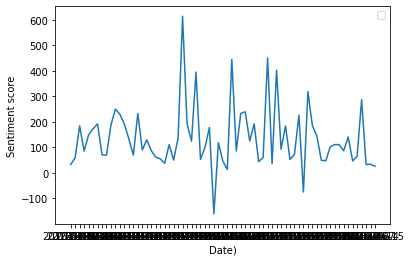

In [44]:
aggcompound = aggcompound.sort_values('Date', ascending=True)
plt.plot(aggcompound['Date'], aggcompound['compound'])
plt.rcParams['figure.figsize'] = 14, 10
plt.legend()
plt.xlabel("Date)")
plt.ylabel("Sentiment score")

No handles with labels found to put in legend.


Text(0, 0.5, 'Closing stock price')

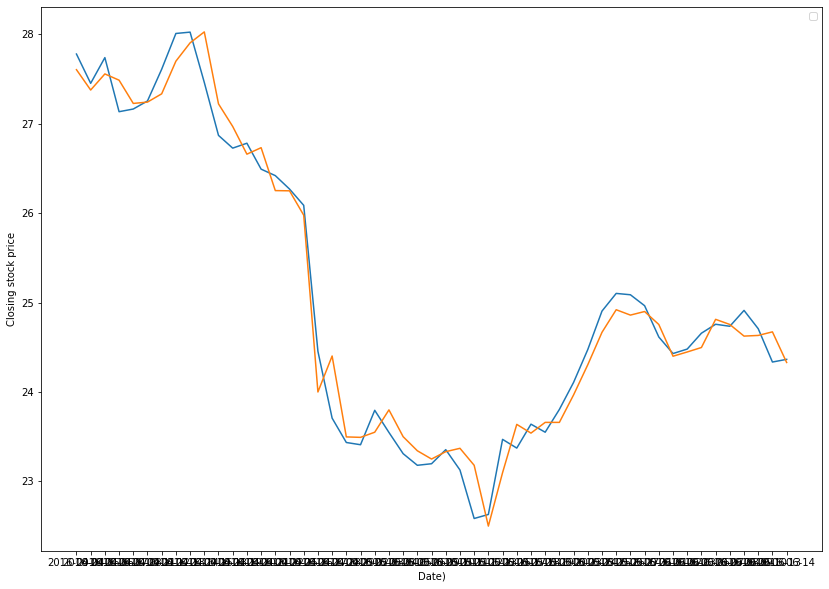

In [45]:
applestockdata = applestockdata.sort_values('Date', ascending=True)
plt.plot(applestockdata['Date'], applestockdata[['Close', 'Open']])
plt.rcParams['figure.figsize'] = 14, 10
plt.legend()
plt.xlabel("Date)")
plt.ylabel("Closing stock price")

In [46]:
#Show everything together:

showtogether=pd.merge (applestockdata, aggcompound, on = 'Date')
showtogether.head()

,Date,Open,High,Low,Close,Adj Close,Volume,compound
0,2016-04-04,27.605000,28.047501,27.567499,27.780001,25.921675,149424800,184.3389
1,2016-04-05,27.377501,27.682501,27.355000,27.452499,25.616087,106314800,85.5317
2,2016-04-06,27.557501,27.745001,27.299999,27.740000,25.884350,105616400,148.7332
3,2016-04-07,27.487499,27.605000,27.030001,27.135000,25.319826,127207600,172.3864
4,2016-04-08,27.227501,27.442499,27.042500,27.165001,25.347818,94326800,192.1832


No handles with labels found to put in legend.


Text(0, 0.5, 'Closing stock price')

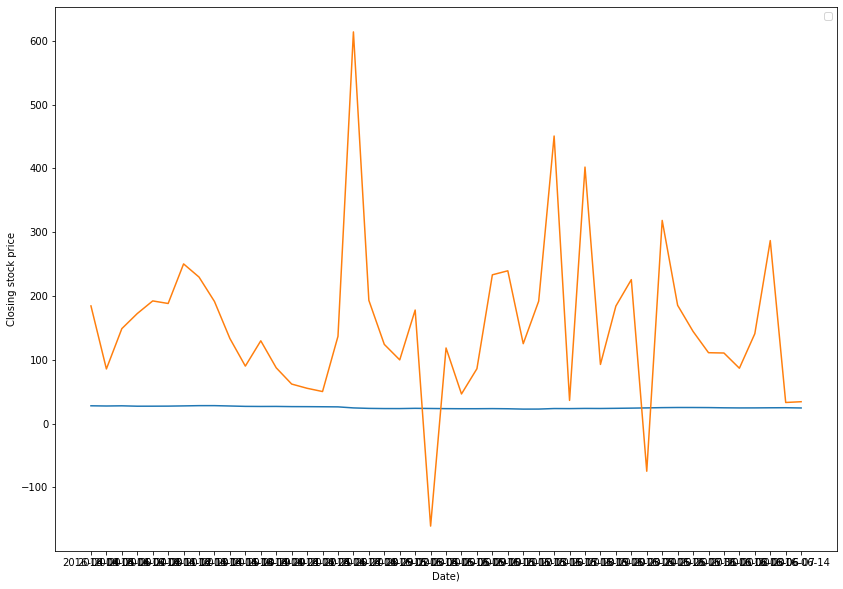

In [47]:
showtogether = showtogether.sort_values('Date', ascending=True)
plt.plot(showtogether['Date'], showtogether[['Close', 'compound']])
plt.rcParams['figure.figsize'] = 14, 10
plt.legend()
plt.xlabel("Date)")
plt.ylabel("Closing stock price")

Text(0, 0.5, 'Sentiment score')

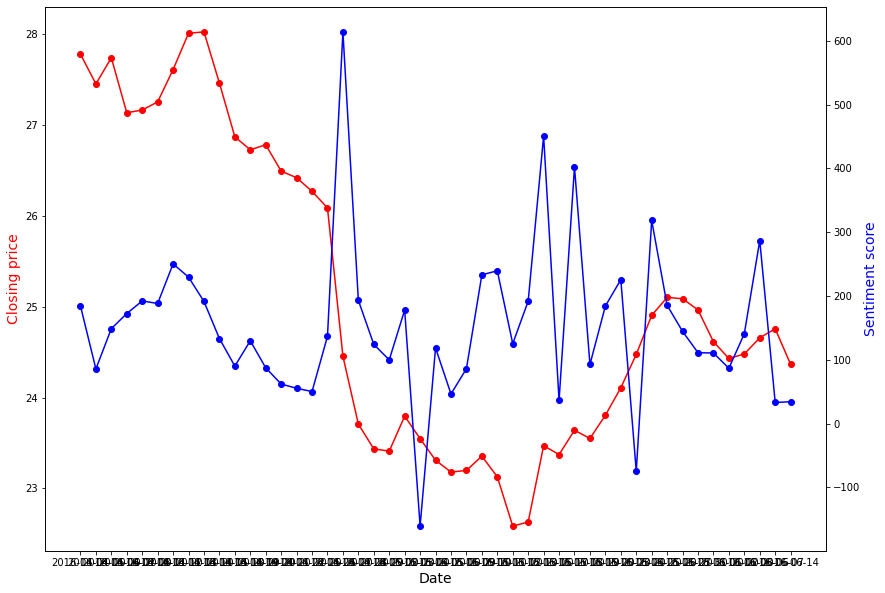

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(showtogether.Date, showtogether.Close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Closing price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(showtogether.Date, showtogether.compound, color="blue",marker="o")
ax2.set_ylabel("Sentiment score",color="blue",fontsize=14)

In [49]:
twittersentiment.to_csv

<bound method NDFrame.to_csv of                   Tweet Id        Date   Hour  ... compound  Time_Hour Time_minute
0       730872698260180992  2016-05-12  21:30  ...   0.0000         21          30
1       718563488470183936  2016-04-08  22:17  ...  -0.2960         22          17
2       724648885315092480  2016-04-25  17:18  ...   0.0000         17          18
3       731117873788129280  2016-05-13  13:44  ...   0.4199         13          44
4       730756237235625984  2016-05-12  13:47  ...   0.0000         13          47
...                    ...         ...    ...  ...      ...        ...         ...
127886  720008598642819074  2016-04-12  22:00  ...   0.4995         22          00
127887  730392506098024448  2016-05-11  13:41  ...   0.3818         13          41
127888  727506685972078593  2016-05-03  14:34  ...   0.0000         14          34
127889  735049665629069312  2016-05-24  10:07  ...   0.0000         10          07
127890  729415230694940672  2016-05-08  20:58  ...   0.

In [50]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link2( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

#df = twittersentiment.DataFrame(data = [[1,2],[3,4]], columns=['Col 1', 'Col 2'])
create_download_link2(showtogether)

##Aggregated Compound Score - Test

Let's do the same method with our Test dataset.

In [51]:
#Let's do the same method with the Test data
list_of_TEST_tweets = X_test['toanalyze'].to_list()
print('List of Test Tweets: ', list_of_TEST_tweets[:10])

scoresTest = []
for everytweet in list_of_TEST_tweets:
    vs = analyser.polarity_scores(everytweet)
    scoresTest.append(vs)
Test_data = pd.DataFrame(list_of_TEST_tweets, columns= ['Tweetcontent'])
Test_data2 = pd.DataFrame(scoresTest)
Test_dataset= pd.concat([Test_data,Test_data2], axis=1)
Test_dataset.head()

Test_dataset[['Tweet Id','Tweet content']] = pd.DataFrame(Test_dataset.Tweetcontent.str.split(' ',1).tolist(), columns = ['Tweet Id','Tweet content'])

Test_dataset['Tweet Id'] = Test_dataset['Tweet Id'].astype(int)

Testmerge = pd.merge (X_test, Test_dataset, on = 'Tweet Id')


twittersentiment_test = Testmerge[['Tweet Id', 'Date', 'Hour','Tweet content_y', 'compound']].copy()

twittersentiment_test2 = twittersentiment_test[['Date', 'compound']].copy()

aggcompound_test = twittersentiment_test2.groupby(['Date']).compound.sum().reset_index()
aggcompound_test

List of Test Tweets:  ["737284895165190144 #Apple Store's worst feature? Customers, says ex-employee     - CNET. Read more: https://t.co/eaNHnslO9W $AAPL", '725061413027205120 New stock traders should read this article https://t.co/WJFaIw7OGS $IWM #finance #stocks $AAPL', "730004470017314817 Apple: It's Time To Fix The Mac App Store https://t.co/UfSI2wF2z0 $ADBE $ADSK $MSFT $AAPL", '725099398103896064 #Apple iPhone sales drop, results miss expectations. Read more: https://t.co/nRCqOTnB92 $AAPL', '730397084340387840 Apple Stock Price: 93.04 #apple $AAPL', '729649817161498624 RT @ValaAfshar: Apple has $233 billion in cash. It could buy all\n\n—@NFL teams\n—@NBA teams\n—@MLB teams\n—@NHL teams\n\n...and still have $80 bi…', '730121594731790336 #Apple Designed the iPad Smart Cover You Really Want. Read more: https://t.co/9hV7nNiHiI $AAPL', '727525013843234817 Didn’t like @tim_cook interview last night, but $AAPL over 2 Day highs is a technical long for a bounce. Below those 2X lows is a sh

,Date,compound
0,2016-04-02,6.0752
1,2016-04-03,11.2486
2,2016-04-04,40.2419
3,2016-04-05,25.2867
4,2016-04-06,29.2746
...,...,...
64,2016-06-05,13.9700
65,2016-06-06,73.3013
66,2016-06-07,9.4575
67,2016-06-14,5.4722


No handles with labels found to put in legend.


Text(0, 0.5, 'Sentiment score')

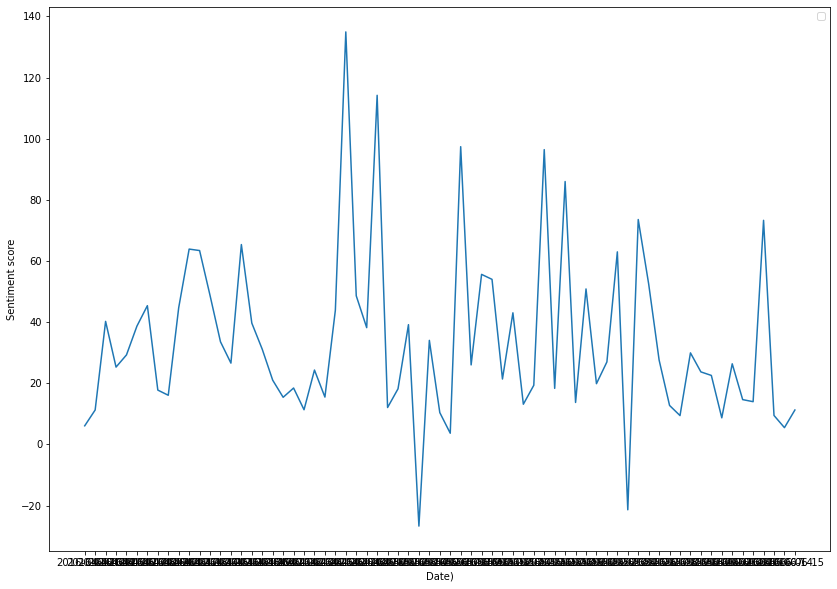

In [52]:
aggcompound_test = aggcompound_test.sort_values('Date', ascending=True)
plt.plot(aggcompound_test['Date'], aggcompound_test['compound'])
plt.rcParams['figure.figsize'] = 14, 10
plt.legend()
plt.xlabel("Date)")
plt.ylabel("Sentiment score")

In [53]:
showtogether_test=pd.merge (applestockdata, aggcompound_test, on = 'Date')

Text(0, 0.5, 'Sentiment score')

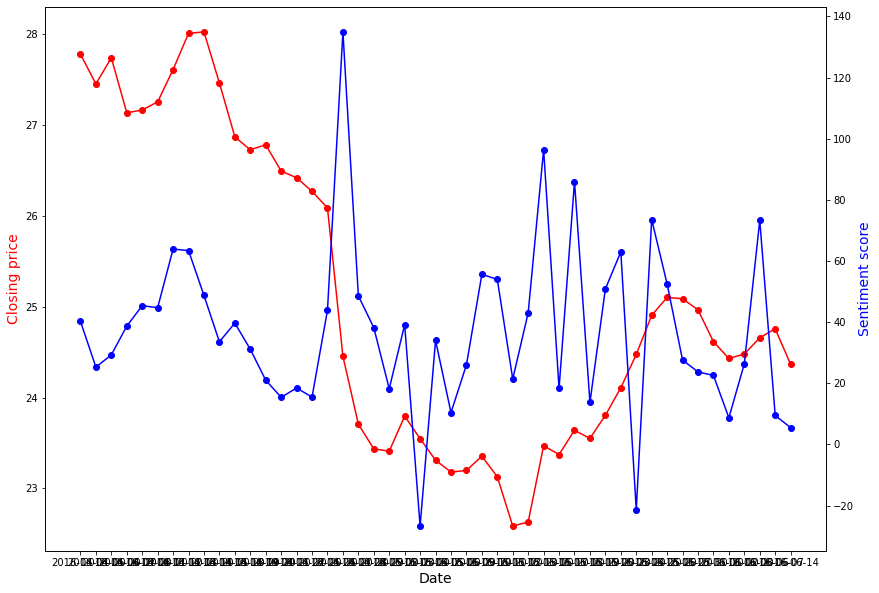

In [54]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(showtogether_test.Date, showtogether_test.Close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Closing price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(showtogether_test.Date, showtogether_test.compound, color="blue",marker="o")
ax2.set_ylabel("Sentiment score",color="blue",fontsize=14)

In [55]:
create_download_link2(showtogether_test)

##Average Copmound Score - Train

Text(0, 0.5, 'Sentiment score')

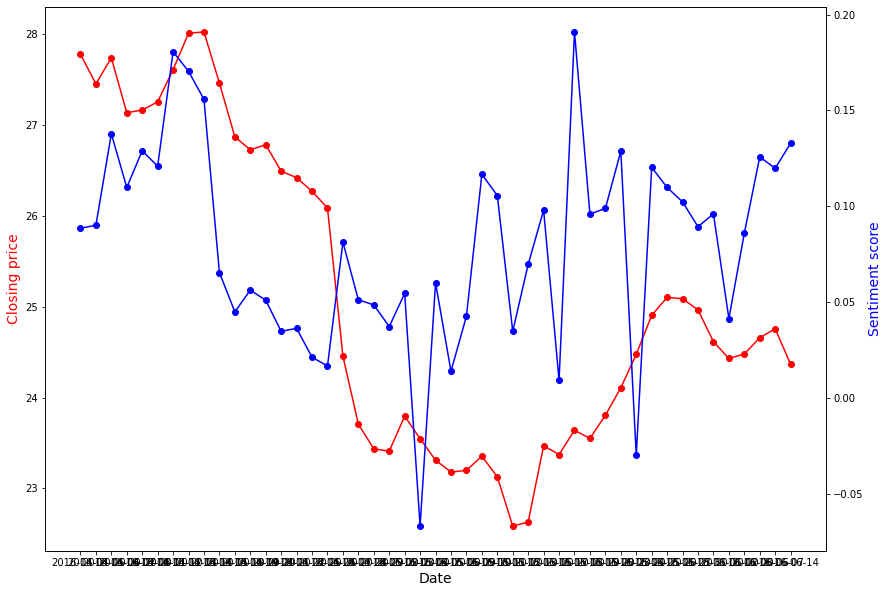

In [56]:
avgcompound=twittersentiment2.groupby(['Date']).compound.mean().reset_index()

avgcompound = avgcompound.sort_values('Date', ascending=True)

showtogether_avg_train=pd.merge (applestockdata, avgcompound, on = 'Date')

fig,ax = plt.subplots()
# make a plot
ax.plot(showtogether_avg_train.Date, showtogether_avg_train.Close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Closing price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(showtogether_avg_train.Date, showtogether_avg_train.compound, color="blue",marker="o")
ax2.set_ylabel("Sentiment score",color="blue",fontsize=14)

In [57]:
create_download_link2(showtogether_avg_train)

After the correlations of the Train and Test datasets of the aggregated score were calculated with the Daily closing price were close (Test vs Closing price: 0.403450; Train vs Closing price: 0.420407), our project team decided that the Whole dataset should be analysed, to get a more closest understanding of the reality. Instead, an other split was done later, by checking the correlation for a longer and a shorter time period.

#Every Tweet Shown Together

Now we will create a plot with all the data we have, meaning that every tweet will be analysed at once. It also means that we will not care here about Train and Test split. However, when we plot the charts, we will see the correlation of a certain time interval compares to the correlation of the complementary interval.

In [58]:
list_of_tweets_all = tweets['toanalyze'].to_list()

In [59]:
scores_all = []
for everytweet in list_of_tweets_all:
    vs = analyser.polarity_scores(everytweet)
    scores_all.append(vs)

data_all = pd.DataFrame(list_of_tweets_all, columns= ['Tweetcontent'])
data2_all = pd.DataFrame(scores_all)

every_tweet_score= pd.concat([data_all,data2_all], axis=1)

In [60]:
every_tweet_score

,Tweetcontent,neg,neu,pos,compound
0,743055905214889984 #APPLE TRIES to Limit #Goog...,0.000,1.000,0.000,0.0000
1,743055905193857024 #APPLE TRIES to Limit #Goog...,0.000,1.000,0.000,0.0000
2,743055497725673472 What calls do I sell on $tw...,0.079,0.827,0.094,0.1027
3,743055311909441536 Good for $AAPL pay? https:/...,0.169,0.482,0.349,0.3612
4,743055468315185152 Apple may again see a super...,0.000,0.830,0.170,0.5994
...,...,...,...,...,...
159859,716328052892897280 “And in a world where you g...,0.000,0.781,0.219,0.6808
159860,716327961641680898 Why Intel Is Supporting #Ap...,0.000,0.791,0.209,0.4404
159861,716327961641639937 Why Intel Is Supporting #Ap...,0.000,0.791,0.209,0.4404
159862,716326132476461058 Here's why #Apple is flying...,0.000,0.812,0.188,0.5719


In [61]:
every_tweet_score[['Tweet Id','Tweet content']] = pd.DataFrame(every_tweet_score.Tweetcontent.str.split(' ',1).tolist(), columns = ['Tweet Id','Tweet content'])

every_tweet_score['Tweet Id'] = every_tweet_score['Tweet Id'].astype(int)

tweet_alldata = pd.merge (tweets, every_tweet_score, on = 'Tweet Id')

#Let's create a new dataframe, where we will include only those columns that needed for the further analysis
tweet_alldata_everycolumn = tweet_alldata[['Tweet Id', 'Date', 'Hour','Tweet content_y', 'compound']].copy()

tweet_alldata_tomerge = tweet_alldata_everycolumn[['Date', 'compound']].copy()


In [62]:
tweet_alldata_tomerge

,Date,compound
0,2016-06-15,0.0000
1,2016-06-15,0.0000
2,2016-06-15,0.1027
3,2016-06-15,0.3612
4,2016-06-15,0.5994
...,...,...
159859,2016-04-02,0.6808
159860,2016-04-02,0.4404
159861,2016-04-02,0.4404
159862,2016-04-02,0.5719


##Average Compound Score - ALL

Text(0, 0.5, 'Sentiment score')

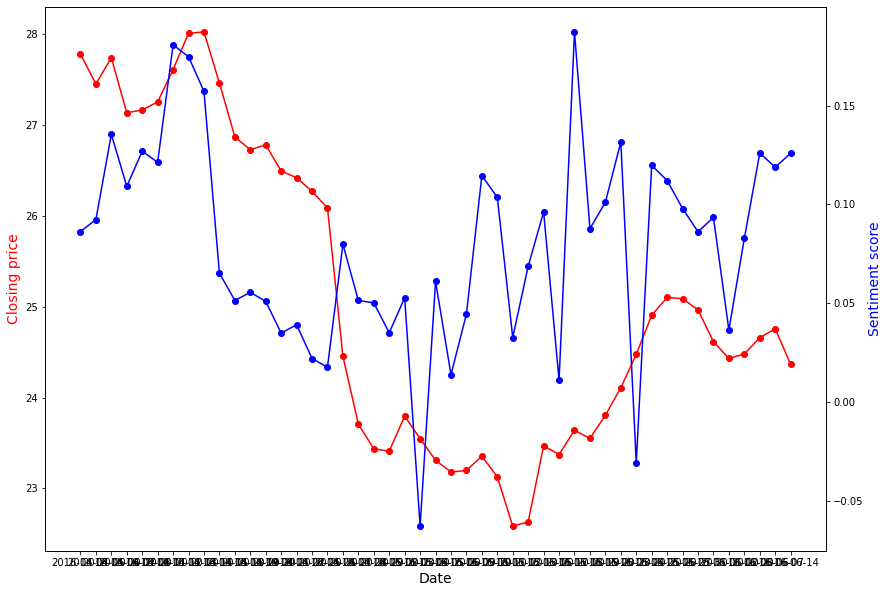

In [63]:
avgcompound_all=tweet_alldata_tomerge.groupby(['Date']).compound.mean().reset_index()

avgcompound_all = avgcompound_all.sort_values('Date', ascending=True)

showtogether_avg_all=pd.merge (applestockdata, avgcompound_all, on = 'Date')

fig,ax = plt.subplots()
# make a plot
ax.plot(showtogether_avg_all.Date, showtogether_avg_all.Close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Closing price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(showtogether_avg_all.Date, showtogether_avg_all.compound, color="blue",marker="o")
ax2.set_ylabel("Sentiment score",color="blue",fontsize=14)

In [64]:
showtogether_avg_all.head()

,Date,Open,High,Low,Close,Adj Close,Volume,compound
0,2016-04-04,27.605000,28.047501,27.567499,27.780001,25.921675,149424800,0.086245
1,2016-04-05,27.377501,27.682501,27.355000,27.452499,25.616087,106314800,0.092349
2,2016-04-06,27.557501,27.745001,27.299999,27.740000,25.884350,105616400,0.135367
3,2016-04-07,27.487499,27.605000,27.030001,27.135000,25.319826,127207600,0.109141
4,2016-04-08,27.227501,27.442499,27.042500,27.165001,25.347818,94326800,0.126903


In [65]:
create_download_link2(showtogether_avg_all)

##Aggregated Compound Score - ALL

And now let's see the same for the aggregated compound score.

Text(0, 0.5, 'Sentiment score')

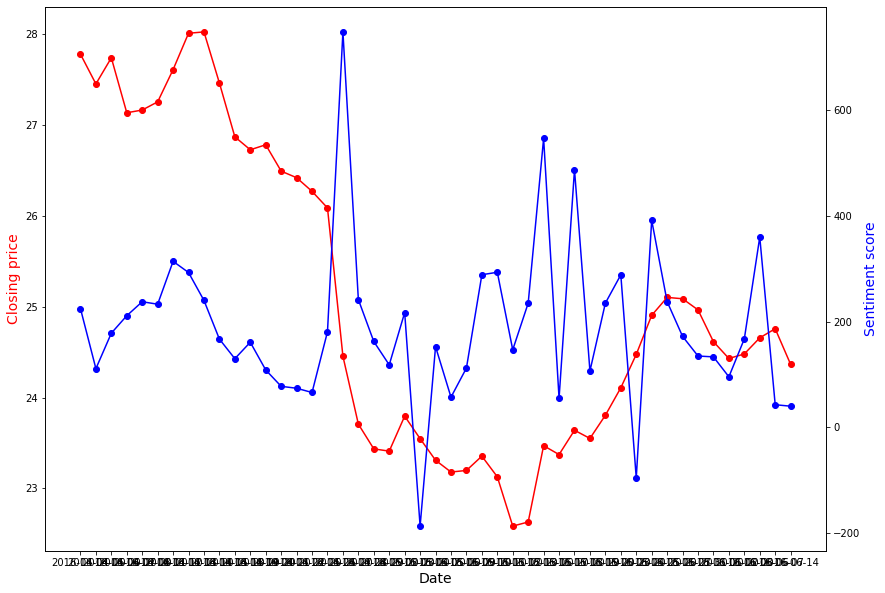

In [66]:
aggcompound_all=tweet_alldata_tomerge.groupby(['Date']).compound.sum().reset_index()

aggcompound_all = aggcompound_all.sort_values('Date', ascending=True)

showtogether_agg_all=pd.merge (applestockdata, aggcompound_all, on = 'Date')

fig,ax = plt.subplots()
# make a plot
ax.plot(showtogether_agg_all.Date, showtogether_agg_all.Close, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Closing price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(showtogether_agg_all.Date, showtogether_agg_all.compound, color="blue",marker="o")
ax2.set_ylabel("Sentiment score",color="blue",fontsize=14)


In [72]:
create_download_link2(showtogether_agg_all)